In [241]:
import pandas as pd
import numpy as np
import ConfigParser, os
import seaborn as sea
import matplotlib.pyplot as plt
%matplotlib inline

sea.set(font_scale=2)  # crazy big

%matplotlib inline

def df_mensajes_log_a_df(patron, nombrearchivo):
    mensajes = !grep '$patron' $nombrearchivo
    qss_mensajes = pd.DataFrame([val.split(' / ') for val in mensajes])
    return qss_mensajes

def obtener_patrones(nombrearchivo):
    patrones = ! awk ' { print $1 " " $2 " " $3 " " $4 " " $5 } ' $nombrearchivo  | sort -u
    return patrones

def nombres_modelos(logfile_name):    
    logdir_name = os.path.dirname(logfile_name)
    config = ConfigParser.ConfigParser()
    config.readfp(open(logfile_name))
    
    fn_parallelroot = config.get('logfiles', 'parallelroot')
    fn_top = config.get('logfiles', 'top')

    atomics = { mod_name: os.path.join(logdir_name, fn_mod) for (mod_name, fn_mod) 
               in config.items('logfiles')}
               #if mod_name not in ("top", "parallelroot")}
    return atomics

In [ ]:
# Leo el log.
mensajes = df_mensajes_log_a_df('0 / L / Y /', 'exp_55667/result_start_10.10_02.log')


In [381]:
# Metodo para categorizar de que tipo de votante se trata.
def categorizar(va):
    if va < -1:
        return 'A'
    elif va > 1:
        return 'B'
    else:
        return 'I'


In [315]:
# busco las celdas que terminan en 0.
mensajes = mensajes[mensajes[4].str.match("opinion\(.,.,0\)")]
mensajes['modelo'] = mensajes[4].str[-4:].replace("(", "").replace(")", "")

In [316]:
# borramos columnas que sobran
for c in [0, 1, 2, 4, 5, 7]:
    try:
        del mensajes[c]
    except:
        pass


In [317]:
# renombro columnas
mensajes.columns = ['t', 'opinion', 'modelo']
# ajusto el tipo de datos xq no lo infirio bien.
mensajes['opinion'] = pd.to_numeric(mensajes['opinion'])
# filtro los valores que estan por fuera de la malla
mensajes = mensajes[( -3<= mensajes['opinion']) & (mensajes['opinion'] <=3)]

In [318]:
#Filtro los mensajes duplicados por los shockers. Basicamente si hay un duplicado me quedo con el del shocker.
mensajes = mensajes[~mensajes.duplicated(['t','modelo'], keep='last')]

In [319]:
# Completo los valores faltantes (solo se emiten valores al cambiar)
mensajes_curados= mensajes.pivot(index='t', columns='modelo').fillna(method='bfill').reset_index()
mensajes_curados.columns = mensajes_curados.columns.droplevel()


In [320]:
# Lo vuelvo a formatlo largo y renombro las columnas
mensajes_curados = mensajes_curados.melt(id_vars='')
mensajes_curados.columns = ['t','modelo', 'opinion']


In [341]:
# Categorizo los votos para poder contar cuantas celdas hay de cada tipo.
mensajes_curados['voto']=mensajes_curados['opinion'].apply(categorizar)
del mensajes_curados['modelo']

In [373]:
# Cuento los datos y me preparo para filtrar.
datos_para_plot = mensajes_curados.groupby(['t', 'voto']).count().reset_index()
datos_para_plot = datos_para_plot.pivot(index='t', columns='voto').reset_index()
datos_para_plot['index'] = range(0, datos_para_plot.shape[0])

In [377]:
# Vuelvo a formato long.
datos_para_plot = datos_para_plot.melt(id_vars=['t', 'index'])


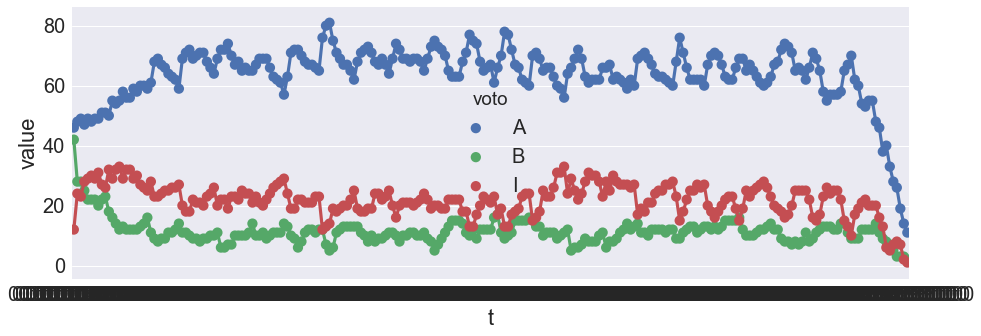

In [380]:
plt.figure(figsize=(15,5))
sea.pointplot(data=datos_para_plot[datos_para_plot['index'] % 10 == 0], x='t', y='value', hue='voto')

In [383]:
# Codigo de Pedro

import re

N = 10
M = 10
found = [[0] * M for i in range(0,N)]
cntFound = 0
A, B, C = [], [], []
for ln in reversed(open("exp_55677/result_start_10.10_01.log","r").readlines()):
    if cntFound == N * M:
        break
    if ln.startswith("0 / L / Y /"):

        cell = ln.split('/')[4]
        p = re.compile("opinion(.*)\([0-9]+\)")
        s = p.findall(cell)[0]
        x, y, z = int(s[1]), int(s[3]), int(s[5])
        if(z == 0 and found[x][y] == 0):
            cntFound += 1
            found[x][y] = 1
            
            val  = ln.split('/')[6]
            #print([x,y])
            val = float(val.strip())
            
            if(val < -1): 
                A.append(val)
            elif(val >= -1 and val <= 1):
                B.append(val)
            elif(val > 1):
                C.append(val)
print(len(A))
print(len(B))
print(len(C))


0
100
0


In [2]:
!ls


exp_55555  exp_56667	 result_start_10.10_01	result_start_10.10_05
exp_55667  exp_57777	 result_start_10.10_02	result_start_10.10_06
exp_55677  experimentos  result_start_10.10_03	result_start_10.10_07
exp_55777  parser.ipynb  result_start_10.10_04
